# Foundations of Computational Economics #26

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Polyline class for piecewise linear curve approximation

<img src="_static/img/lab.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/echmNfDfaD8](https://youtu.be/echmNfDfaD8)

Description: Precomputation of complex curves in the equilibrium model (coding from scratch).

- In this exercise we are writing a useful class to represent linearly
  interpolated functions and correspondences.  
- It will be useful for various models, including those in midterm projects.  
- The main use case for the class is precomputing and storing function
  approximations, before analyzing them further.  
- This is useful when computing functions directly is costly  

### Modeling market equilibrium

- Consider the following product market
  - Demand and supply be given by the code and plots below  
- Supply is subject to batched production technology, where each batch requires a certain fixed
  cost, leading to the wavy structure of the curve  
- Demand curved is affected by three groups of customers with different willingness to pay
  whose effect is clearly seen compared to the aggregated average  
- Assume that each point on the curves are hard to compute  


The task is to compute the equilibrium given the functions `demand(p)` and `supply(p)`

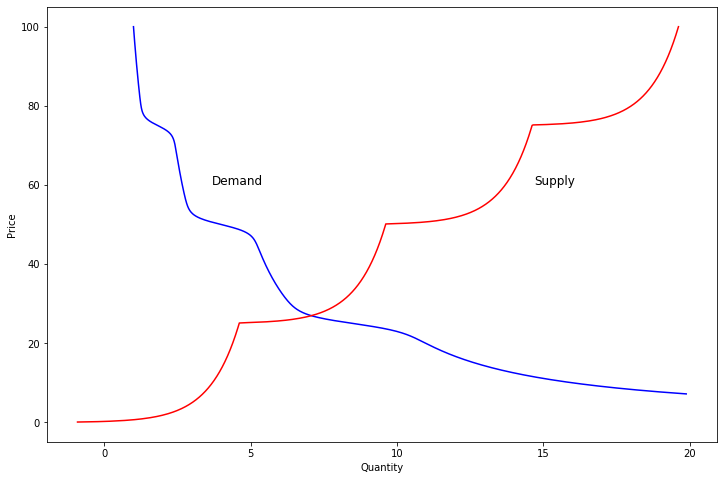

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
np.seterr(all=None, divide='ignore', over=None, under=None, invalid='ignore')  # turn off sqrt(-1) warning

def supply(p):
    '''Vectorized function to compute supply'''
    const = 5*np.arange(10)  # cost thresholds
    p = np.asarray(p).reshape((1,-1))  # row vector
    s = np.kron(np.ones((const.size,1)),p)  # repeat rows
    for i,c in enumerate(const):
        s[i,:] = np.log(s[i,:]*.2-c)+c+3  # separate transform for each row
    return np.nanmax(s,axis=0)

def demand(p):
    '''Vectorized function to compute demand'''
    res = np.asarray(100/p + 1/(1+np.exp(p-75))
                           + 2/(1+np.exp(p-50))
                           + 3/(1+np.exp(p-25)))
    res[res>20] = np.nan  # avoid large numbers for plots
    return res

def plotline(fun,lbl=None,ax=None,**kwargs):
    # quick plotting function on given axis
    if ax==None:
        ax = plt.axes()
    pr = np.linspace(0,100,1000)
    ax.plot(fun(pr),pr,**kwargs)
    if lbl:
        ax.text(fun(60)+1,60,lbl,fontsize=12)
    ax.set_xlabel('Quantity')
    ax.set_ylabel('Price')
    return ax

ax = plotline(demand,lbl='Demand',c='b')
plotline(supply,lbl='Supply',c='r',ax=ax)
plt.show()

### Straightforward approach

- Write down the market equilibrium condition $ S(p)-D(p)=0 $ and use any of the solvers
  we have came across in this course to solver the equation  
- Downside: have to compute supply and demand at each iteration, potentially large number of times!  

### Precomputation approach

1. Approximate supply and demand curves with piecewise linear curves
  - requires a fixed and known number of calculations of supply and demand
  - can consciously trade computational load vs. accuracy  
1. Compute the intersection of the piecewise linear approximations  


Need a tool for that!

#### Polyline class

We will write a simple class `polyline` that:

- holds the coordinates of computed points of the line  
- implements simple operations on the lines  
- contains methods to compute intersection points  

### Specification for the class

The methods which have to be implemented:

- `__init__` with three arguments: vector of $ x $, vector of $ y $, and an optional label
  - all types of that are convertible to NumPy array should be accepted in $ x $ and $ y $ arguments  
- `__repr__` as string representation  
- `__call__` should return the interpolated values of $ f(x) $ for the passed
  array $ x $. The output should be the same shape as the input.
  Use [scipy.interpolate.interp1d()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)
  function, and return nan for extrapolated values (set bounds_error=False, fill_value=‘nan’).  
- `__add__` should concatenate polylines  
- `plot` should make a plot of the polyline  
- `intersect` should return the array of intersection points for two polylines, using the method below  
- `self_intersect` should return the array of intersection points within one polyline.  

### Task

1. Write the code for the polyline class  
1. Along class code development, write unit tests to each of the methods  
1. Run graphical tests below for intersection functions  
1. Compute the equilibrium in the model above using the polyline class  

#### Finding the intersecting point of two line segments

Given two line segments in $ \mathbb{R}^2 $ with endpoint
coordinates as

$$
(x^1_1,y^1_1),(x^1_2,y^1_2) \text{  and  } (x^2_1,y^2_1),(x^2_2,y^2_2),
$$

where superscripts indicate the segment, subscripts indicate beginning
and end of the line, find whether the segments intersect, and if so,
what is the intersection point.

Let intersection be given by $ (x_0,y_0) $, and introduce two more
variables $ t_1 $ and $ t_2 $ that equal to the distance from
the starting points $ (x^1_1,y^1_1) $ and $ (x^2_1,y^2_1) $ to
the intersection point, relative to the corresponding segment lengths.
Then we can write the following system of equations

$$
\begin{eqnarray*}
(x^1_2 - x^1_1) \cdot t_1 &=& x_0 - x^1_1 \\
(x^2_2 - x^2_1) \cdot t_2 &=& x_0 - x^2_1 \\
(y^1_2 - y^1_1) \cdot t_1 &=& y_0 - y^1_1 \\
(y^2_2 - y^2_1) \cdot t_2 &=& y_0 - y^2_1 \\
\end{eqnarray*}
$$

In matrix notation $ Az=b $ where

$$
A=
\begin{pmatrix}
x^1_2 - x^1_1 & 0 & -1 & 0 \\
0 & x^2_2 - x^2_1 & -1 & 0 \\
y^1_2 - y^1_1 & 0 & 0 & -1 \\
0 & y^2_2 - y^2_1 & 0 & -1 \\
\end{pmatrix},\;\;
b=\begin{pmatrix}
-x^1_1\\
-x^2_1\\
-y^1_1\\
-y^2_1\\
\end{pmatrix},\;\;
z=(t_1,t_2,x_0,y_0)
$$

Then if solution exists, compute, check $ t_1 $ and $ t_2 $ - If
both belong to $ [0,1] $, the intersection point exists and is given
by the computed $ (x_0,y_0) $ - Otherwise, it the segments do not
intersect

In [2]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

class polyline():
    '''Class that implements the linearly interpolated function'''

    # Write your code here

In [3]:
# write unit tests here
import unittest
# see examples at https://docs.python.org/3/library/unittest.html

class TestDemo(unittest.TestCase):
    """Example of how to use unittest in Jupyter"""

    def test1(self):
        '''first test'''
        self.assertTrue(True)

    # add more here

# this is the way to run tests
if __name__ == '__main__':
    # tweaking for Jupyter Notebook
    unittest.main(argv=['first-arg-is-ignored'], exit=False)
    # from command line
    # unittest.main()

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### Graphical test

The correctness of calculated intersection points is easiest to check
with a **picture**

In [4]:
# Graphical test
N=10
p1 = polyline(np.random.rand(N),np.random.rand(N),'first line')
p2 = polyline(np.random.rand(N),np.random.rand(N),'second line')
intrs=p1.intersect(p2)

p1.plot()
p2.plot()
if intrs.size>0:
    plt.scatter(x=intrs[:,0],y=intrs[:,1],c='red')
    print('Intersection points', intrs.size//2)
plt.legend()
plt.show()

intrs=p1.self_intersect()
p1.plot()
if intrs.size>0:
    plt.scatter(x=intrs[:,0],y=intrs[:,1],c='red')
    print('Intersection points', intrs.size//2)
plt.legend()
plt.show()

TypeError: polyline() takes no arguments

#### Back to the equilibrium model

- create two polylines to represent supply and demand  
- compute the intersection point  
- plot  

In [ ]:
# Write your code here

#### Further learning resources

- Example of precomputation in computed visual effects (<6min)
  [https://www.youtube.com/watch?v=PJ4dJgGEOrc](https://www.youtube.com/watch?v=PJ4dJgGEOrc)  

In [8]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

class polyline():
    '''Class that implements the linearly interpolated function'''

    def __init__(self,x,y,label='no label'):
        '''Initializer of the polyline object
        '''
        self.x,self.y = np.asarray(x,dtype=float).ravel(),np.asarray(y,dtype=float).ravel()
        if self.x.size != self.y.size:
            raise ValueError('The input arguments to polyline should be the same length')
        self.label = '{:s}'.format(label)  # string label

    def __len__(self):
        '''Length of the polyline'''
        return self.x.size

    def __repr__(self):
        '''String representation of polyline'''
        return 'Polyline with {} points labeled "{}"\nx={}\ny={}'.format(len(self),self.label,self.x,self.y)

    def __call__(self,x):
        '''Returns the values of the polyline computed for given points x'''
        interp = interpolate.interp1d(self.x,self.y,bounds_error=False, fill_value=np.nan)
        return interp(x)

    def __add__(self,other):
        '''Overload of + to concatinate two polylines'''
        if not isinstance(other,polyline):
            raise TypeError('Only polyline can be added to another polyline')
        x = np.concatenate((self.x, other.x))
        y = np.concatenate((self.y, other.y))
        label = self.label + ' + ' + other.label
        return polyline(x,y,label=label)

    def plot(self,ax=None,**kwargs):
        '''Makes a plot of polyline'''
        if not ax:
            ax = plt.axes()
        ax.plot(self.x,self.y,label=self.label,**kwargs)
        return ax

    def intersect(self,other):
        '''Return the 2-dim numpy array of intersection points between two polylines (in row)'''
        if not isinstance(other,polyline):
            raise TypeError('Only polyline can be added to another polyline')
        ub = (len(self)-1)*(len(other)-1)
        out = np.empty((ub,2))  # space for the intersection point
        k = 0  # number of intersection points so far
        for x11,y11,x12,y12 in zip(self.x,self.y,self.x[1:],self.y[1:]):
            for x21,y21,x22,y22 in zip(other.x,other.y,other.x[1:],other.y[1:]):
                pp = self.__intersect_segments(x11,y11,x12,y12,x21,y21,x22,y22)
                if pp:
                    out[k,0],out[k,1] = pp
                    k += 1
        out = out[:k,:]
        return out

    def self_intersect(self):
        '''Return the 2-dim numpy array of self-intersection points (in row)'''
        ub = (len(self)-1)**2
        out = np.empty((ub,2))  # space for the intersection point
        k = 0  # number of intersection points so far
        for x11,y11,x12,y12 in zip(self.x,self.y,self.x[1:],self.y[1:]):
            for x21,y21,x22,y22 in zip(self.x,self.y,self.x[1:],self.y[1:]):
                pp = self.__intersect_segments(x11,y11,x12,y12,x21,y21,x22,y22)
                if pp:
                    out[k,0],out[k,1] = pp
                    k += 1
        out = out[:k,:]
        return out


    def __intersect_segments(self,*args):
        '''Find intersection point of a segment, or return None'''
        # unpack parameters
        x11,y11,x12,y12=args[:4] #first line segment
        x21,y21,x22,y22=args[4:] #second line segment
        # check if segmets are identical
        if np.all(np.abs(np.asarray(args[:4])-np.asarray(args[4:]))<1e-10):
            return None
        # check if segmets share a point
        if np.all(np.abs(np.asarray(args[:2])-np.asarray(args[4:6]))<1e-10):
            return None
        if np.all(np.abs(np.asarray(args[:2])-np.asarray(args[6:]))<1e-10):
            return None
        if np.all(np.abs(np.asarray(args[2:4])-np.asarray(args[4:6]))<1e-10):
            return None
        if np.all(np.abs(np.asarray(args[2:4])-np.asarray(args[6:]))<1e-10):
            return None
        # bounding box check: whether intersection is possible in principle
        bb = ( min(x11,x12)<max(x21,x22) and min(x21,x22)<max(x11,x12) and
               min(y11,y12)<max(y21,y22) and min(y21,y22)<max(y11,y12) )
        if not bb:
            return None
        # form system of equations
        A = np.array([[x12-x11,0,-1,0],[0,x22-x21,-1,0],[y12-y11,0,0,-1],[0,y22-y21,0,-1]])
        b = np.array([-x11,-x21,-y11,-y21])
        t1,t2,x0,y0 = np.linalg.solve(A,b)
        if 0 <= t1 <= 1 and 0 <= t2 <= 1:
            return x0,y0
        else:
            return None

In [9]:
# write unit tests here
import unittest
# see examples at https://docs.python.org/3/library/unittest.html

class TestPolyline(unittest.TestCase):
    '''Tests for the polyline class'''

    def test_init(self):
        '''Tests for the initializer'''
        self.assertEqual(str(polyline([1,2,5,6],[[5,6,5,6]])),
                        'Polyline with 4 points labeled "no label"\nx=[1. 2. 5. 6.]\ny=[5. 6. 5. 6.]')
        self.assertEqual(str(polyline([[1],[2],[5],[6]],[[5,6,5,6]])),
                        'Polyline with 4 points labeled "no label"\nx=[1. 2. 5. 6.]\ny=[5. 6. 5. 6.]')
        self.assertEqual(str(polyline(np.array([[1],[2],[5],[6]]),[[5,6,5,6]])),
                        'Polyline with 4 points labeled "no label"\nx=[1. 2. 5. 6.]\ny=[5. 6. 5. 6.]')
        self.assertRaises(ValueError,polyline,[1],[2,4])
        self.assertRaises(ValueError,polyline,[1],[2],6758)
        self.assertRaises(ValueError,polyline,[1,2,],'string')

    def test_call(self):
        a = polyline(np.array([[1],[2],[5],[6]]),[[5,6,5,6]])
        dt0 = a([2.3,4,5,23])
        dt1 = np.asarray([5.9,5.33333333,5.,np.nan])
        self.assertAlmostEqual(dt0[:3].sum(),dt1[:3].sum())
        self.assertTrue(np.isnan(dt0[3]))

    def test_add(self):
        a = polyline([0,0,1,2],[9,9,3,4])
        b = polyline([9,9,1,2],[9,8,7,8])
        c = a + b
        with self.assertRaises(TypeError):
            a + 'string'
            a + 56
        self.assertListEqual(list(c.x),[0,0,1,2,9,9,1,2])
        self.assertListEqual(list(c.y),[9,9,3,4,9,8,7,8])

    def test_intersect(self):
        a = polyline([0,0,1,2],[9,9,3,4])
        b = polyline([9,9,1,2],[9,8,7,8])
        with self.assertRaises(TypeError):
            a.intersect('string')
            a.intersect(56)


    # add more here

# this is the way to run tests
if __name__ == '__main__':
    # tweaking for Jupyter Notebook
    unittest.main(argv=['first-arg-is-ignored'], exit=False)
    # from command line
    # unittest.main()

.....
----------------------------------------------------------------------
Ran 5 tests in 0.014s

OK


Intersection points 14


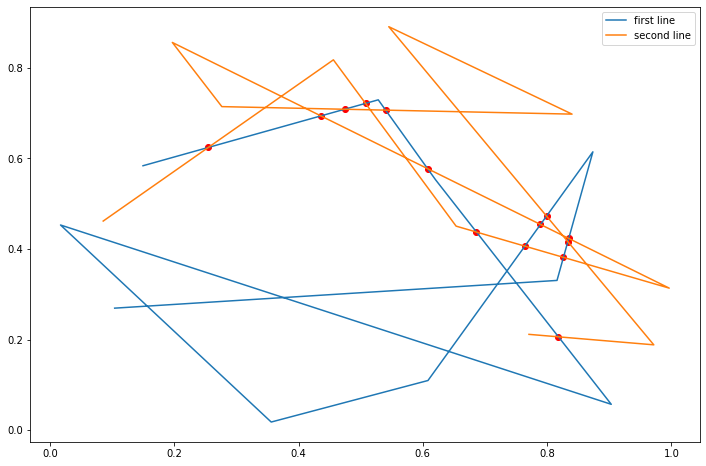

Intersection points 12


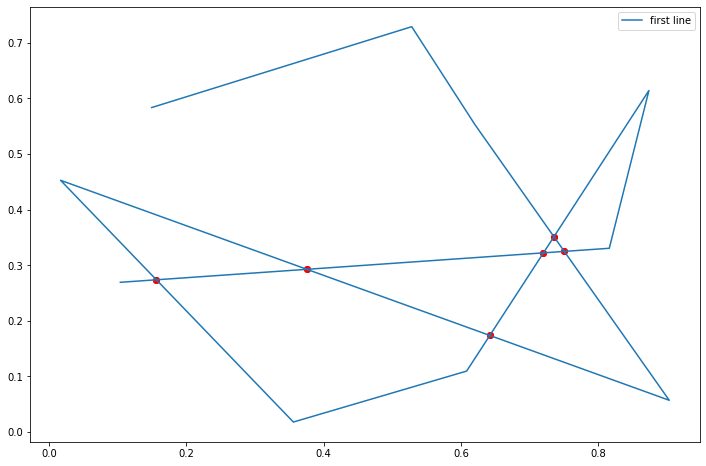

In [10]:
# Graphical test
N=10
p1 = polyline(np.random.rand(N),np.random.rand(N),'first line')
p2 = polyline(np.random.rand(N),np.random.rand(N),'second line')
intrs=p1.intersect(p2)

ax = p1.plot()
p2.plot(ax=ax)
if intrs.size>0:
    plt.scatter(x=intrs[:,0],y=intrs[:,1],c='red')
    print('Intersection points', intrs.size//2)
plt.legend()
plt.show()

intrs=p1.self_intersect()
p1.plot()
if intrs.size>0:
    plt.scatter(x=intrs[:,0],y=intrs[:,1],c='red')
    print('Intersection points', intrs.size//2)
plt.legend()
plt.show()

In [ ]:
pr = np.linspace(0,100,50)
p1 = polyline(pr,demand(pr),label='demand')
p2 = polyline(pr,supply(pr),label='supply')
intrs=p1.intersect(p2)

ax = p1.plot()
p2.plot(ax=ax)
if intrs.size>0:
    plt.scatter(x=intrs[:,0],y=intrs[:,1],c='red')
    print('Intersection points', intrs.size//2)
plt.legend()
plt.show()
print('Equilibrium price is {} and quantity is {}'.format(intrs[0,0],intrs[0,1]))